In [1]:
import sys,os
import setGPU
import numpy as np
import h5py
import random

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
import sklearn
from sklearn.metrics import confusion_matrix
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random

#sys.path.append(os.path.abspath(os.path.join('../ADgvae/')))
from pathlib import Path
from importlib import reload  
import os.path as osp
sys.path.append(os.path.abspath(os.path.join('../')))
sys.path.append(os.path.abspath(os.path.join('../IDEC/')))
import data_utils.data_processing as data_proc
from data_utils.data_processing import GraphDataset, DenseEventDataset
from training_utils.metrics import cluster_acc
from models.models import GraphAE, IDEC 
from training_utils.training import target_distribution,pretrain_ae_graph, train_test_ae_graph,train_test_idec_graph
from training_utils.activation_funcs  import get_activation_func

import torch
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.data import Data, Batch, DataLoader
from data_utils.data_processing import GraphDataset,DenseEventDataset
from training_utils.metrics import cluster_acc

from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

import matplotlib.colors as colors
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

from sklearn.manifold import TSNE

import matplotlib.colors as colors

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

setGPU: Setting GPU to: 1


In [2]:
DATA_PATH = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/clustering/inputs/'
TRAIN_NAME = 'background_chan3_passed_ae_l1.h5'
filename_bg = DATA_PATH + TRAIN_NAME 
in_file = h5py.File(filename_bg, 'r') 
file_dataset = np.array(in_file['dataset']) ##[:,:,[0,2,4,5,6,7]]
num_classes=4
random.shuffle(file_dataset)
file_dataset = file_dataset#[:int(5e4)]
#trying temp to see what happens if we separate peak of 0s from eta and phi (activation function and pi cyclicity was changed in the model accordingly)
#file_dataset[:,1:,4] = np.where(file_dataset[:,1:,1]==0.,0.,file_dataset[:,1:,4]+3.0)
#file_dataset[:,1:,5] = np.where(file_dataset[:,1:,1]==0.,0.,file_dataset[:,1:,5]+3.4)

input_shape=[16,5]
n_top_proc=3
batch_size=256

prepared_dataset,datas =  data_proc.prepare_graph_datas(file_dataset,input_shape[0],n_top_proc = n_top_proc,connect_only_real=True)

pid_weight = data_proc.get_relative_weights(prepared_dataset[:,1:,1].reshape(prepared_dataset[:,1:,1].shape[0]*prepared_dataset[:,1:,1].shape[1]),mode='max')
#pid_weight = [1.,1.4,5.,5.]
pid_weight = torch.tensor(pid_weight).float().to(device)

train_dataset = GraphDataset(datas)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,drop_last=True) #,num_workers=5


Preparing dataset, check that the feature indexing corresponds to your dataset!
Preparing the dataset of 62578 events
Dataset of 62578 events prepared


/afs/cern.ch/user/n/nchernya/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/nump

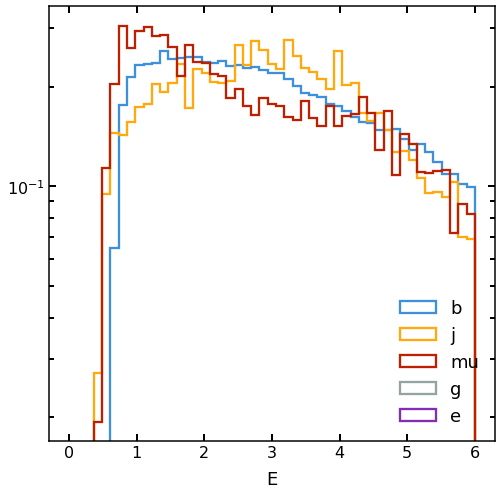

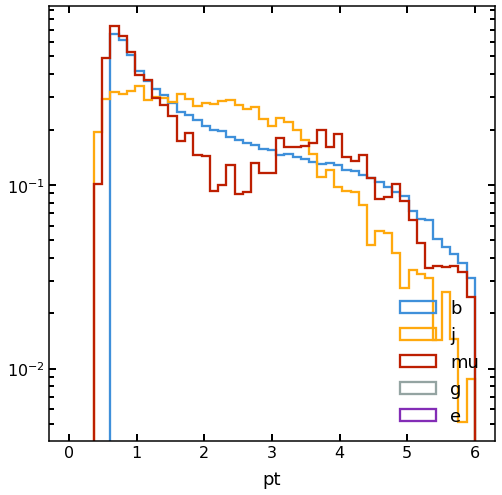

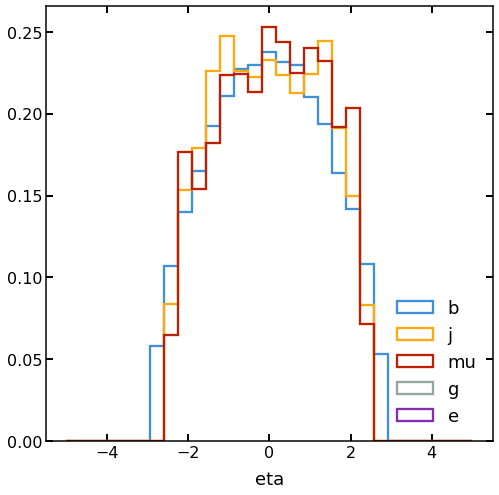

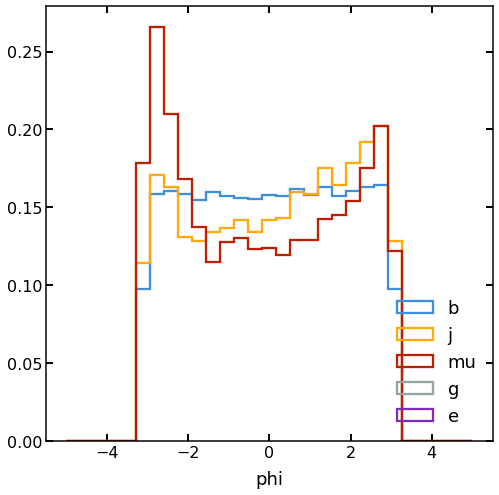

In [18]:
for i,name in zip([2,3,4,5],'E,pt,eta,phi'.split(',')):
    plt.figure(figsize=(8,8))
    bins = np.linspace(-5,5,30)
    if i==2 or i==3:
        bins = np.linspace(0,6,50)
        plt.semilogy()
    kwargs={'linewidth':2.3, 'fill':False, 'density':True,'histtype':'step'}
    for pid_name, pid in zip(['b','j','mu','g','e'],[1,2,3,4,5]):
        _ = plt.hist(prepared_dataset[:,1:,i][prepared_dataset[:,1:,1]==pid],bins=bins,**kwargs,label=pid_name)
    plt.xlabel(name)
    plt.legend(loc='lower right')

In [37]:
import json 
import models.models as models
reload(models)
from models.models import load_DenseAE, load_IDEC, load_GraphAE 


load_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/clustering/trained_output/graph/'
n_run = 'run_9'
load_dir+=n_run+'/'
path_model_ae = load_dir+'/best_model_AE.pkl'
#path_model_ae = load_dir+'/pretrained_AE_epoch_41.pkl'
#path_model_idec = load_dir+'/idec_model_epoch_47.pkl'
path_params = load_dir+'parameters.json'
params_dict = json.loads(json.load(open(path_params)))

model_AE = load_GraphAE(params_dict, device, path_model_ae)
#model = load_IDEC(model_AE,params_dict, device, path_model_idec)

In [4]:
num_clusters_dict = {}

for num_cluster in [3]:
    hidden_channels =[8, 12, 16, 20, 25, 30 ]
    latent_dim = 5
    activation=torch.nn.LeakyReLU(negative_slope=0.5)
    dropout=0.0
    model_AE = GraphAE(input_shape = input_shape,
                        hidden_channels =hidden_channels,
                        latent_dim = latent_dim,
                        activation=activation,
                        dropout=dropout)
    model = IDEC(AE = model_AE,
                input_shape = input_shape, 
                hidden_channels = hidden_channels,
                latent_dim =latent_dim,
                n_clusters=num_cluster,
                alpha=1,
                device=device,
                pretrain_path='data_graph/graph_ae_pretrain.pkl'
    ).to(device)

    model.load_state_dict(torch.load(
"/eos/user/n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/IDEC/data_graph/graph_ae_pretrain_newloss_parallel_1mln_fullmodel_num_clust_{}.pkl".format(num_cluster)))

    latent_pred = []
    true_labels = []
    model.eval() 
    
    pred_features = np.array([model.forward(d.to(device))[0].data.cpu().numpy() for i,d in enumerate(train_loader)]) 
    pred_features_met = np.array([model.forward(d.to(device))[1].data.cpu().numpy() for i,d in enumerate(train_loader)]) 
    latent_pred = np.array([model.forward(d.to(device))[3].data.cpu().numpy() for i,d in enumerate(train_loader)])
    pred_labels = np.array([model.forward(data.to(device))[2].data.cpu().numpy().argmax(1) for i,data in enumerate(train_loader)]) #argmax(1) ##index (cluster nubmber) of the cluster with the highest probability q.
    true_labels = np.array([data.y.cpu().numpy() for i,data in enumerate(train_loader)])
    #reshape 
    latent_pred = np.reshape(latent_pred,(latent_pred.shape[0]*latent_pred.shape[1],latent_pred.shape[2]))
    pred_labels = np.reshape(pred_labels,pred_labels.shape[0]*pred_labels.shape[1])
    true_labels = np.reshape(true_labels,true_labels.shape[0]*true_labels.shape[1])


    emb_input = []  
    #for i,d in enumerate(train_loader):
    #    model.forward(d.x.to(device),d.edge_index.to(device),d.batch.to(device))
    #    emb_input.append(model.ae.embedded_input.detach().cpu())
    #emb_input = np.array(emb_input)

    acc, nmi, ari,reassignment  = model.validateOnCompleteTestData(true_labels,pred_labels)

    print('Acc {:.4f}'.format(acc),
        ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari))
    predicted_reassigned = np.array([reassignment[item] for item in pred_labels])
    
    idx = np.random.choice(list(range(latent_pred.shape[0])), 3000)
    num_clusters_dict[num_cluster] = {}
    num_clusters_dict[num_cluster]['sil_score'] = silhouette_score(latent_pred[idx], predicted_reassigned[idx])
    num_clusters_dict[num_cluster]['db_score'] = davies_bouldin_score(latent_pred[idx], predicted_reassigned[idx])
    num_clusters_dict[num_cluster]['ch_score'] = calinski_harabasz_score(latent_pred[idx], predicted_reassigned[idx])


Acc 0.3446 , nmi 0.0002 , ari 0.0002


In [38]:
latent_pred = []
true_labels = []
model_AE.eval() 

pred_features = np.array([model_AE.forward(d.to(device))[0].data.cpu().numpy() for i,d in enumerate(train_loader)]) 
pred_features_met = np.array([model_AE.forward(d.to(device))[1].data.cpu().numpy() for i,d in enumerate(train_loader)]) 
latent_pred = np.array([model_AE.forward(d.to(device))[2].data.cpu().numpy() for i,d in enumerate(train_loader)])
true_labels = np.array([data.y.cpu().numpy() for i,data in enumerate(train_loader)])
#reshape 
latent_pred = np.reshape(latent_pred,(latent_pred.shape[0]*latent_pred.shape[1],latent_pred.shape[2]))
true_labels = np.reshape(true_labels,true_labels.shape[0]*true_labels.shape[1])


In [39]:
#t = file_dataset[:int(1e3),:,2:]
#t = t.reshape((t.shape[0])*t.shape[1],t.shape[2])

#t = np.vstack(emb_input)

t = file_dataset[:int(1e4),1:,1:]
t = t.reshape((t.shape[0])*t.shape[1],t.shape[2])

pred_features_small = pred_features[:,:,num_classes:]

pr_f = np.expand_dims(np.argmax(np.exp(pred_features[:,:,0:num_classes]),axis=-1),axis=-1)
pred_features_small = np.concatenate([pr_f,pred_features[:,:,num_classes:]],axis=-1)

pred_features_2 = pred_features_small.reshape((pred_features_small.shape[0])*pred_features_small.shape[1],pred_features_small.shape[2])

t_met = file_dataset[:,0:1,[2,5]]
t_met = t_met.reshape((t_met.shape[0])*t_met.shape[1],t_met.shape[2])
pred_met = pred_features_met.reshape((pred_features_met.shape[0]*pred_features_met.shape[1],pred_features_met.shape[2]))

    

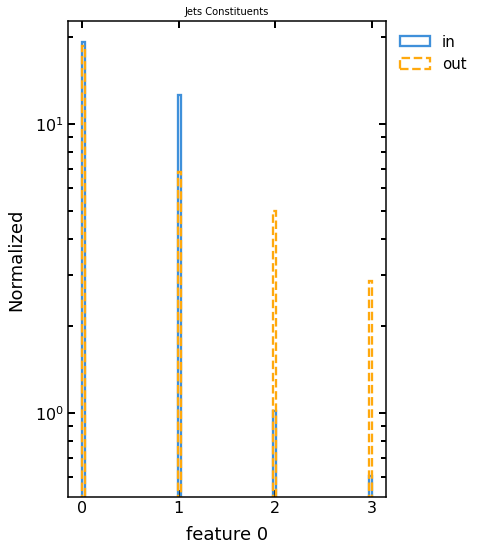

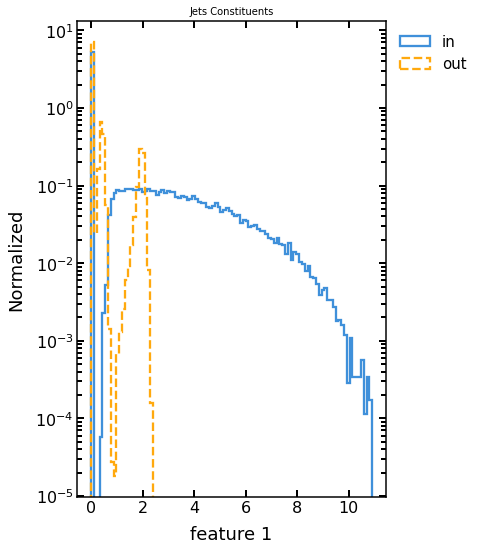

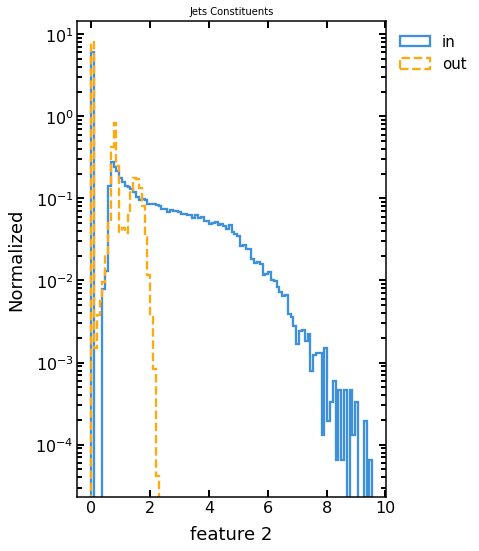

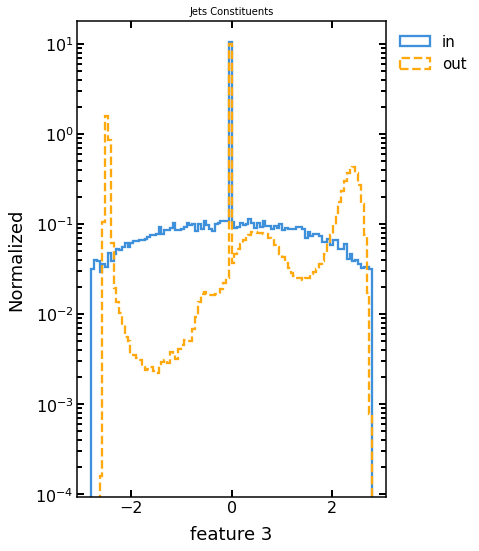

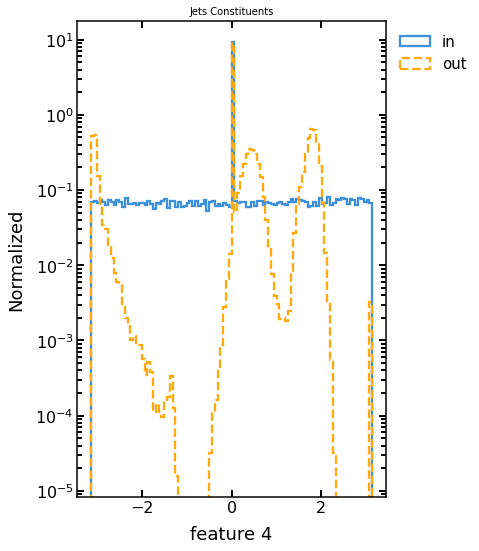

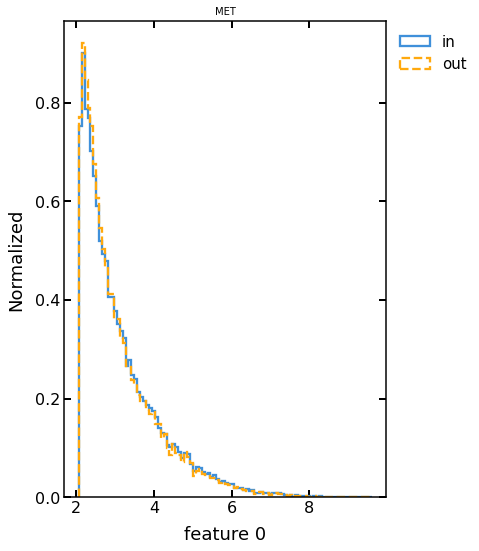

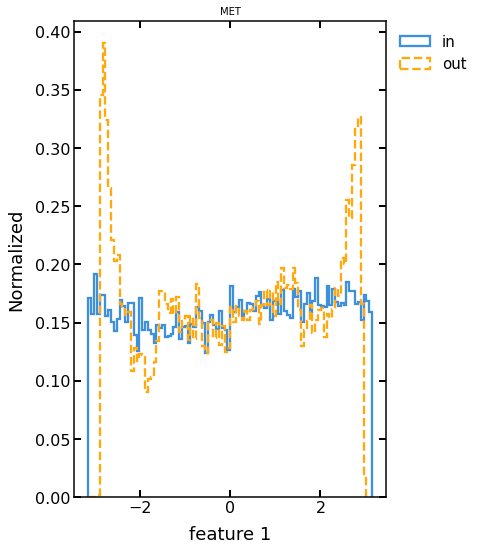

In [40]:
sys.path.append(os.path.abspath(os.path.join('../../')))
import vande.util.util_plotting as vande_plot
reload(vande_plot)


vande_plot.plot_features([t,pred_features_2], 'feature' ,
                             'Normalized' , 'Jets Constituents', 
                             plotname='test',
                             legend=['in','out'],
                              ylogscale=True)
    
vande_plot.plot_features([t_met,pred_met], 'feature' ,
                             'Normalized' , 'MET', 
                             plotname='test',
                             legend=['in','out'],
                              ylogscale=False)

In [7]:
X_embedded = TSNE(n_components=2,verbose=1, perplexity=20, n_iter=1000, learning_rate=200
                 ).fit_transform(latent_pred[idx])

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...
[t-SNE] Computed neighbors for 3000 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.839916
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.452858
[t-SNE] KL divergence after 1000 iterations: 0.612330


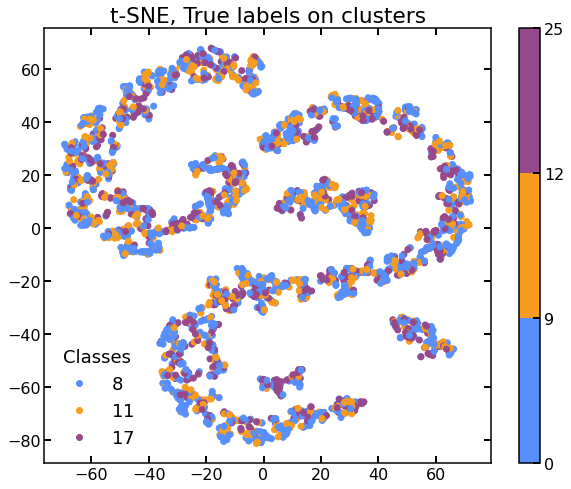

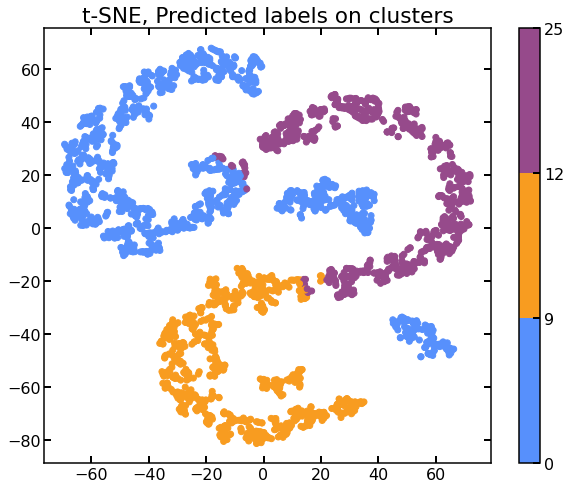

In [8]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')


cmap = plt.cm.rainbow #rainbow
cmap = (colors.ListedColormap(['#5790fc', '#f89c20', '#e42536', '#964a8b'])
        .with_extremes(over='0.25', under='0.75'))
#norm = colors.BoundaryNorm(np.arange(1, 26, 1), cmap.N)
norm = colors.BoundaryNorm([0,9,12,25], cmap.N)

fig = plt.figure(figsize=(10,8))

#top_proc_mask = np.isin(true_labels[idx], result1[:5])
scatter = plt.scatter(X_embedded[:,0],X_embedded[:,1], c=true_labels[idx],cmap=cmap, norm=norm)
plt.title('t-SNE, True labels on clusters')
cb = plt.colorbar()
# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

#ax.add_artist(legend1)


fig = plt.figure(figsize=(10,8))
plt.scatter(X_embedded[:,0],X_embedded[:,1], c=np.array(predicted_reassigned)[idx],cmap=cmap, norm=norm)
plt.title('t-SNE, Predicted labels on clusters')
cb = plt.colorbar()

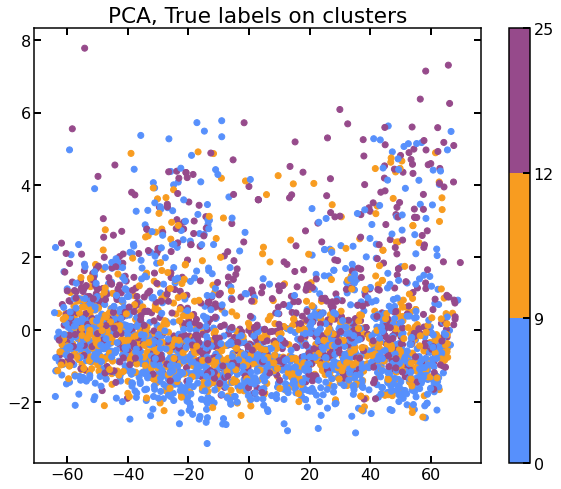

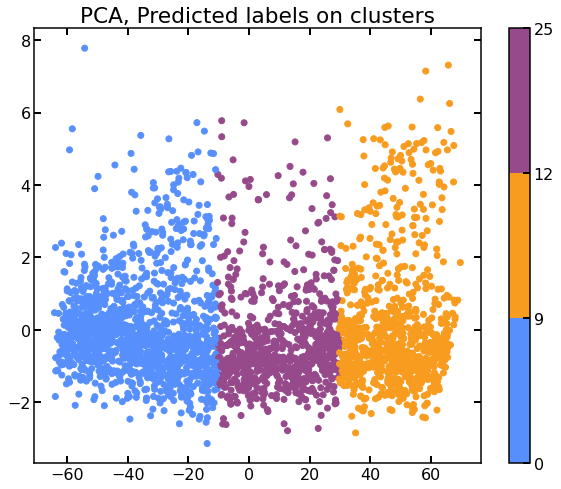

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import colors


pca = PCA(n_components=2)
principalComponents = pca.fit_transform(np.array(latent_pred))

pc1 = principalComponents[:,0][idx]
pc2 = principalComponents[:,1][idx]




fig = plt.figure(figsize=(10,8))
plt.scatter(pc1,pc2, c=true_labels[idx],cmap=cmap, norm=norm, marker='o')
plt.title('PCA, True labels on clusters')
cb = plt.colorbar()



fig = plt.figure(figsize=(10,8))
plt.scatter(pc1,pc2, c=predicted_reassigned[idx],cmap=cmap, norm=norm)
plt.title('PCA, Predicted labels on clusters')
cb = plt.colorbar()

In [41]:
s0 = pred_features_small.shape[0]
s1 = pred_features_small.shape[1]
s2 = pred_features_small.shape[2]
pred_reshaped = pred_features_small.reshape((s0,batch_size,int(s1/batch_size),s2))
pred_reshaped = pred_reshaped.reshape((pred_reshaped.shape[0]*pred_reshaped.shape[1],pred_reshaped.shape[2],pred_reshaped.shape[3]) )

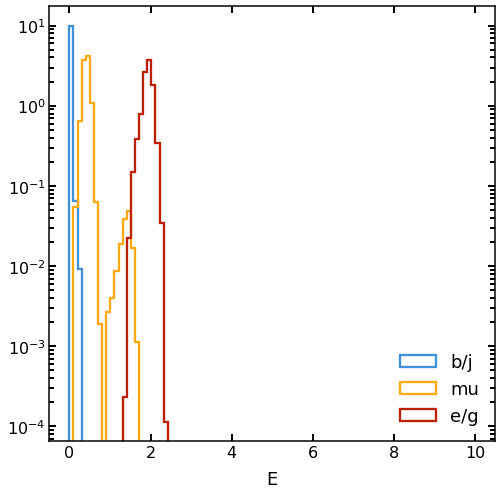

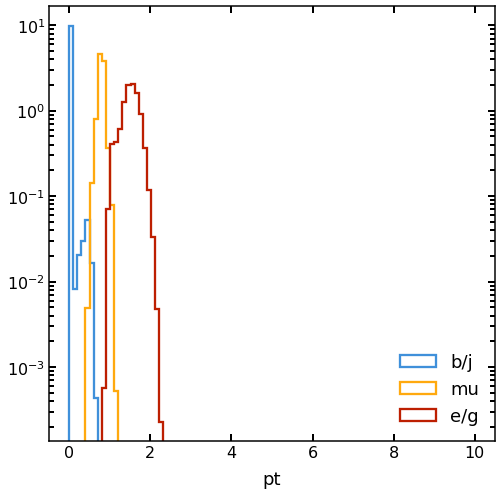

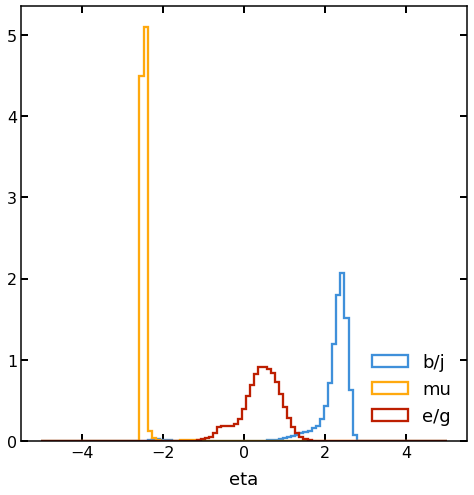

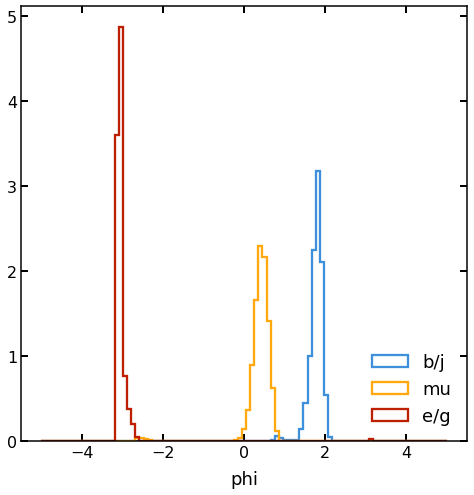

In [42]:
for i,name in zip([1,2,3,4],'E,pt,eta,phi'.split(',')):
    plt.figure(figsize=(8,8))
    bins = np.linspace(-5,5,100)
    if i==1 or i==2:
        bins = np.linspace(0,10,100)
        plt.semilogy()
    kwargs={'linewidth':2.3, 'fill':False, 'density':True,'histtype':'step'}
    #for pid_name, pid in zip(['0','b/j','mu','e/g'],[0,1,2,3]):
    #for pid_name, pid in zip(['0','b','j','mu','g','e'],[0,1,2,3,4,5]):
    for pid_name, pid in zip(['b/j','mu','e/g'],[1,2,3]):
        mask = pred_reshaped[:,:,0]==pid
        _ = plt.hist(pred_reshaped[:,:,i][mask],bins=bins,**kwargs,label=pid_name)
    plt.xlabel(name)
    plt.legend(loc='lower right')
    #plt.semilogy()

(188, 4096, 10)